# Quickstart


`AutoEmulate`'s goal is to make it easy to create an emulator for your simulation. Here's the basic workflow:


In [1]:
from autoemulate.experimental.compare import AutoEmulate
from autoemulate.experimental.emulators import *

from autoemulate.experimental.simulations.projectile import Projectile

import warnings
warnings.filterwarnings("ignore")

## Toy simulation

Before we build an emulator with AutoEmulate, we need to get a set of input/output pairs from our simulation to use as training data.

Below is a toy simulation for a projectile's motion with drag (see [here](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) for details). The simulation includes:
- Inputs: drag coefficient (log scale), velocity
- Outputs: distance the projectile travelled


In [2]:
projectile = Projectile()

# sample from a simulation
n_samples = 500
x = projectile.sample_inputs(n_samples).float()
y = projectile.forward_batch(x).float()

x.shape, y.shape

Running simulations: 100%|██████████| 500/500 [00:00<00:00, 1.23ksample/s]


(torch.Size([500, 2]), torch.Size([500, 1]))

## Comparing emulators

This is the core of `AutoEmulate`. With a set of inputs / outputs, we can run a full machine learning pipeline, including data processing, model fitting, model selection and hyperparameter optimisation in just a few lines of code. First, let's check the names of the available emulator models.


In [2]:
# Print list of available emulators
AutoEmulate.list_emulators()

,Emulator
0,GaussianProcessExact
1,GaussianProcessExactCorrelated
2,LightGBM
3,SupportVectorMachine
4,RadialBasisFunctions
5,RandomForest
6,MLP
7,EnsembleMLP
8,EnsembleMLPDropout


Now let's initialise an `AutoEmulate` object.

This provides the simulation inputs and outputs, then fits a range of different models to the data, evaluating on witheld test data.

In [4]:
ae = AutoEmulate(x, y)

Comparing models: 100%|██████████| 9.00/9.00 [04:14<00:00, 28.3s/model]


Look at the summary for a comparison of emulator performace.

In [5]:
ae.summarise()

,model_name,x_transforms,y_transforms,config,rmse_test,r2_test,r2_test_std,r2_train,r2_train_std
0,GaussianProcessExact,[StandardizeTransform()],[StandardizeTransform()],{'mean_module_fn': <function zero_mean at 0x30...,6.787354,0.999958,0.000019,0.999918,0.000015
6,MLP,[StandardizeTransform()],[StandardizeTransform()],"{'epochs': 100, 'layer_dims': [64, 32, 16], 'l...",18.337044,0.997671,0.001404,0.998556,0.000358
4,RadialBasisFunctions,[StandardizeTransform()],[StandardizeTransform()],"{'kernel': 'linear', 'degree': 1, 'smoothing':...",25.186934,0.993038,0.001700,0.996167,0.001295
7,EnsembleMLP,[StandardizeTransform()],[StandardizeTransform()],"{'n_emulators': 6, 'epochs': 50, 'layer_dims':...",28.632885,0.988155,0.002779,0.989951,0.002595
3,SupportVectorMachine,[StandardizeTransform()],[StandardizeTransform()],"{'kernel': 'rbf', 'degree': 3, 'gamma': 'auto'...",39.911522,0.953396,0.013705,0.956064,0.006681
1,GaussianProcessExactCorrelated,[StandardizeTransform()],[StandardizeTransform()],{'mean_module_fn': <function poly_mean at 0x30...,38.865971,0.952009,0.052646,0.963624,0.007253
8,EnsembleMLPDropout,[StandardizeTransform()],[StandardizeTransform()],"{'n_emulators': 8, 'epochs': 100, 'layer_dims'...",44.560947,0.931297,0.019386,0.927538,0.012809
5,RandomForest,[StandardizeTransform()],[StandardizeTransform()],"{'n_estimators': 481, 'min_samples_split': 17,...",49.700390,0.896111,0.026512,0.954263,0.008405
2,LightGBM,[StandardizeTransform()],[StandardizeTransform()],"{'num_leaves': 30, 'max_depth': -1, 'learning_...",85.445335,0.097234,0.045736,0.133176,0.008939


Choose an emulator based on the index from the summary dataframe, or quickly get the best result (based on `r2_score`).

In [14]:
best = ae.best_result()
print("Model with id: ", best.id, " performed best: ", best.model_name)

Model with id:  0  performed best:  GaussianProcessExact


Plot the emulator predictions against the simulator outputs.

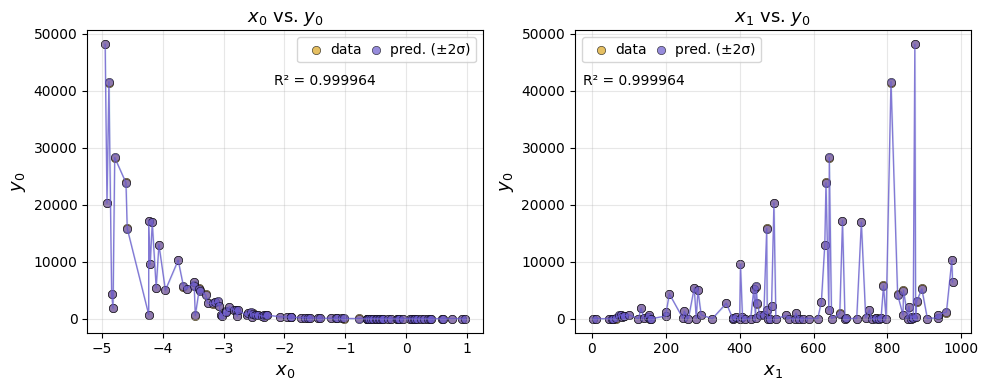

In [13]:
ae.plot(best)

## Predictions

We can use the model to make predictions for new inputs. Emulators in `AutoEmulate` can use the `predict` method to make predictions.


In [8]:
best.model.predict(x[:10])

MultitaskMultivariateNormal(mean shape: torch.Size([10, 1]))

# Saving and loading emulators

Emulators can be saved to disk and loaded again later.

In [9]:
# Make a directory to save Emulator models
import os
path = "my_emulators"
if not os.path.exists(path):
    os.makedirs(path)

Save the best model to disk.

In [10]:
# The use_timestamp paramater ensures a new model is saved each time the save method is called
best_model_saved = ae.save(best, path, use_timestamp=True)
print("Model saved to: ", best_model_saved)

Model saved to:  my_emulators/GaussianProcessExact_20250715_155456


In [11]:
loaded_model = ae.load(best_model_saved)

In [12]:
loaded_model.predict(x[:10])

MultitaskMultivariateNormal(mean shape: torch.Size([10, 1]))